In [1]:
import pymongo
import servidor_mongo as SM
import json
from bson.objectid import ObjectId
from datetime import datetime, timedelta
import utils
import time

import tensorflow as tf
# Importamos la librería de pandas
import pandas as pd
import re
import matplotlib as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import pandas as pd

## Nota: Una variable importante que de no estar almacenada debe darse de igual manera es la distancia entre la antena y el tag -> debería ser un dato almacenado

## Debe estar en centimetros 158
D_ant_tag = 177 

## Leemos el json con los datos de las antenas y el tag
f = open("Ant_tag.json", "r")
c = f.read()
f.close()
js = json.loads(c)

## Establecemos la conexion con el servidor
base_de_datos = SM.obtener_bd()

# Definimos una variable con los atributos de un elemento almacenado por primera vez
# final_data = SM.Ublox_1

## Pruebas de código ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# fecha = datetime.strptime("2022/11/17/ 21:42:28","%Y/%m/%d/ %H:%M:%S")
# print(fecha,type(fecha))
# fecha_str = str(fecha)
# print(fecha_str,type(fecha_str))
# time_0 = '2022/11/17/ 21:42:28'
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## Traemos el ultimo elemento de la lista en el tiempo de lectura
## La idea es poder trabajar con el tiempo anterior a este número
r_0 = base_de_datos.find().sort("_id",-1).limit(1)

for r in r_0:
    id_0 = r

fecha_0 = str(datetime.strptime(str(id_0['hora']),"%Y/%m/%d/ %H:%M:%S"))

time_1 = datetime.strptime(str(id_0['hora']),"%Y/%m/%d/ %H:%M:%S") - timedelta(seconds=1)
fecha_1 = str(time_1)

time_2 = datetime.strptime(str(id_0['hora']),"%Y/%m/%d/ %H:%M:%S") - timedelta(seconds=2)
fecha_2 = str(time_2)

time_3 = datetime.strptime(str(id_0['hora']),"%Y/%m/%d/ %H:%M:%S") - timedelta(seconds=3)
fecha_3 = str(time_3)

time_4 = datetime.strptime(str(id_0['hora']),"%Y/%m/%d/ %H:%M:%S") - timedelta(seconds=4)
fecha_4 = str(time_4)
# Nota: Esto se puede reducir más todavia pero quiero saber si funciona todo primero antes de meterle mano a todo

## Traigo una cantidad de datos desde la base de datos, está a su vez esta limitado con la variable contenida en la clase limit()
## Lo separo en 4 vectores porque no tengo garantía de que todos los datos hayan sido recibidos en orden y con la misma hora
## Existe la posibilidad de que los datos se pierdan en el camino, que la antena deje de mandar datos, que las baterias de los tag se agoten y dejen de enviar datos, que el trafico de red sea demasiado para el ordenador que hace de host del servidor o que el mismo repetidor que ocupo no sea capaz de procesar las instrucciones aunque lo dudo, pero en retrospectiva puede pasar, podría ser victima de un ataque de Ddos

respuestas = base_de_datos.find().sort("_id",-1)#.limit(500)

# tag_1/Ant_1
vect_11 = []
# tag_2/Ant_1
vect_21 = []
# tag_1/Ant_2
vect_12 = []
# tag_2/Ant_2
vect_22 = []

for r in respuestas:
    if(r['Id_tag']== js["tag_1"] and r['Id_ant']==js["Antena_1"]):
        vect_11.append(r)
    elif(r['Id_tag']== js["tag_2"] and r['Id_ant']==js["Antena_1"]):
        vect_21.append(r)
    elif(r['Id_tag']== js["tag_1"] and r['Id_ant']==js["Antena_2"]):
        vect_12.append(r)
    elif(r['Id_tag']== js["tag_2"] and r['Id_ant']==js["Antena_2"]):
        vect_22.append(r)
    else:
        pass

## De los cuatro vector que creamos, los reducimos a dos para poder tener las variables que tienen el mismo tag con antenas diferentes
## El críterio para juntar alguno de los elementos es que tengan la misma hora de captura del dato y que el tag sea igual en ambos casos pero los datos deben ser tomado de diferentes antenas
## En este caso tenemos solo dos antenas y dos tag

vect_1 = []
vect_2 = []
# cargamos los datos al vect_1
for r in vect_11:
    for s in vect_12:
        if(r['hora']==s['hora']):
            vect_1.append(r)
            vect_1.append(s)
            vect_12.remove(s)

# Cargamos los datos al vect_2
for r in vect_21:
    for s in vect_22:
        if(r['hora']==s['hora']):
            vect_2.append(r)
            vect_2.append(s)
            vect_22.remove(s)

## Testeo de variables ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print("~"*50)
print(vect_1[0])
print(vect_1[1])
print("~"*50)
print(vect_2[0])
print(vect_2[1])
# print(vect_1[0]['_id'])
# print(ObjectId(str(vect_1[0]['_id'])))
# # print(vect_1[2])
# # print(vect_1[3])
# # print(vect_1[4])
# # print(vect_1[5])
# print("~"*50)
print(len(vect_1))
print(len(vect_2))
print("~"*50)
print(type(vect_1))
print(type(vect_2))
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


## Para ingresar a los elementos del arreglo y modificarlos
## Actualizo los datos añadiendo el parametro Distancia_ant_tag para guardarlos en la base de datos de MongoDb
## Vector 1
for t in range(int(len(vect_1)/2)):
    D_B,D_A = utils.Distancia_ant_tag(D_ant_tag,vect_1[2*t]['Ang_azimuth'],vect_1[(2*t)+1]['Ang_azimuth'])
    d_a = D_A
    d_b = D_B
    try:
        base_de_datos.update_one(
            {"_id": ObjectId(str(vect_1[2*t]['_id']))},
            {
                "$set":{
                    "Distancia_ant_tag": d_b
                }
            }
        )
        base_de_datos.update_one(
            {"_id": ObjectId(vect_1[(2*t)+1]['_id'])},
            {
                "$set":{
                    "Distancia_ant_tag": d_a
                }
            }
        )
    except:
        pass

## Vector 2
for t in range(int(len(vect_2)/2)):
    try:
        D_B,D_A = utils.Distancia_ant_tag(D_ant_tag,vect_2[2*t]['Ang_azimuth'],vect_2[(2*t)+1]['Ang_azimuth'])
        base_de_datos.update_one(
            {'_id': ObjectId(vect_2[2*t]['_id'])},
            {
                '$set':{
                    "Distancia_ant_tag": D_B
                }
                    
            }
        )
        base_de_datos.update_one(
            {'_id': ObjectId(vect_2[(2*t)+1]['_id'])},
            {
                '$set':{
                    "Distancia_ant_tag": D_A
                }
            }
        )
    except:
        pass
    

# Nota esto podría ser una función pero de momento lo tengo todo junto no más



KeyError: 'Id_ant'

Tenemos la Primera red neuronal

In [30]:
## Iniciamos la parte de correccion por parte de las redes neuronales

respuestas = base_de_datos.find({"Distancia_ant_tag":{"$exists" : True}}).sort("_id",1)#.limit(500)  #1 significa de menor a mayor

# tag_1/Ant_1
vect_11 = []
# tag_2/Ant_1
vect_21 = []
# tag_1/Ant_2
vect_12 = []
# tag_2/Ant_2
vect_22 = []

for r in respuestas:
    if(r['Id_tag']== js["tag_1"] and r['Id_ant']==js["Antena_1"]):
        vect_11.append(r)
    elif(r['Id_tag']== js["tag_2"] and r['Id_ant']==js["Antena_1"]):
        vect_21.append(r)
    elif(r['Id_tag']== js["tag_1"] and r['Id_ant']==js["Antena_2"]):
        vect_12.append(r)
    elif(r['Id_tag']== js["tag_2"] and r['Id_ant']==js["Antena_2"]):
        vect_22.append(r)
    else:
        pass

df_11 = pd.DataFrame(vect_11)
df_21 = pd.DataFrame(vect_21)
df_12 = pd.DataFrame(vect_12)
df_22 = pd.DataFrame(vect_22)

In [31]:
df_11_r =  df_11.drop(['_id','hora','Id_tag','Id_ant'],axis=1)
if('LOS' in df_11_r.columns):
    df_11_r = df_11_r.drop(['LOS'],axis=1)

df_21_r =  df_21.drop(['_id','hora','Id_tag','Id_ant'],axis=1)
if('LOS' in df_21_r.columns):
    df_21_r = df_21_r.drop(['LOS'],axis=1)

df_12_r =  df_12.drop(['_id','hora','Id_tag','Id_ant'],axis=1)
if('LOS' in df_12_r.columns):
    df_12_r = df_12_r.drop(['LOS'],axis=1)

df_22_r =  df_22.drop(['_id','hora','Id_tag','Id_ant'],axis=1)
if('LOS' in df_22_r.columns):
    df_22_r = df_22_r.drop(['LOS'],axis=1)


In [32]:
scaler = MinMaxScaler()
scaler = scaler.fit(df_11_r)

scaler_1 = MinMaxScaler()
scaler_1 = scaler_1.fit(df_21_r)

scaler_2 = MinMaxScaler()
scaler_2 = scaler_2.fit(df_12_r)

scaler_3 = MinMaxScaler()
scaler_3 = scaler_3.fit(df_22_r)

In [34]:
df_11_r[['RSSI','Ang_azimuth','Ang_elevacion','Canal','Altura_ant','Distancia_ant_tag']] = scaler.transform (df_11_r[['RSSI','Ang_azimuth','Ang_elevacion','Canal','Altura_ant','Distancia_ant_tag']])
df_21_r[['RSSI','Ang_azimuth','Ang_elevacion','Canal','Altura_ant','Distancia_ant_tag']] = scaler.transform (df_21_r[['RSSI','Ang_azimuth','Ang_elevacion','Canal','Altura_ant','Distancia_ant_tag']])
df_12_r[['RSSI','Ang_azimuth','Ang_elevacion','Canal','Altura_ant','Distancia_ant_tag']] = scaler.transform (df_12_r[['RSSI','Ang_azimuth','Ang_elevacion','Canal','Altura_ant','Distancia_ant_tag']])
df_22_r[['RSSI','Ang_azimuth','Ang_elevacion','Canal','Altura_ant','Distancia_ant_tag']] = scaler.transform (df_22_r[['RSSI','Ang_azimuth','Ang_elevacion','Canal','Altura_ant','Distancia_ant_tag']])

In [35]:
# Creamos el dataset
def create_dataset (X, times_steps = 1):
    Xs = []
    for i in range(len(X)- times_steps):
        v = X.iloc[i:(i+ times_steps)].values
        Xs.append(v)
    return np.array(Xs)

In [36]:
time_steps = 40
X_test = create_dataset(df_11_r,time_steps)
X_test_1 = create_dataset(df_21_r,time_steps)
X_test_2 = create_dataset(df_12_r,time_steps)
X_test_3 = create_dataset(df_22_r,time_steps)

In [37]:
# Modelo guardado en el PC
#from keras.models import model_from_json
import keras

name_json = "model_conv_malo.json"

# carga el json y crea el modelo
json_file = open(name_json,'r')
loaded_model_json = json_file.read()
json_file.close()

modelo = keras.models.model_from_json(loaded_model_json)
# se cargan los pesos (weights) en el nuevo modelo
modelo.load_weights("model_conv_malo.h5")
print("Modelo cargado desde el PC: ",name_json)
# se evalua el modelo cargado con los datos de los test

Modelo cargado desde el PC:  model_conv_malo.json


In [38]:
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 36, 2, 3)          78        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 1, 3)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 36)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1184      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                      

In [39]:
X_test = np.expand_dims(X_test, -1)
X_test_1 = np.expand_dims(X_test_1, -1)
X_test_2 = np.expand_dims(X_test_2, -1)
X_test_3 = np.expand_dims(X_test_3, -1)

In [40]:
y_pred = modelo.predict(X_test)
y_pred_1 = modelo.predict(X_test_1)
y_pred_2 = modelo.predict(X_test_2)
y_pred_3 = modelo.predict(X_test_3)

23/23 [==============================] - 0s 1ms/step


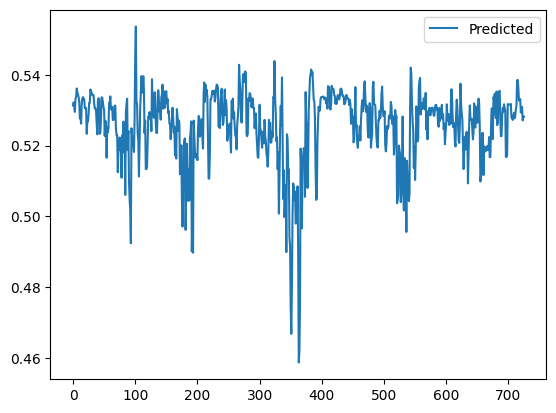

In [41]:
from matplotlib import pyplot as plt

plt.plot(y_pred, label = 'Predicted')
plt.legend()

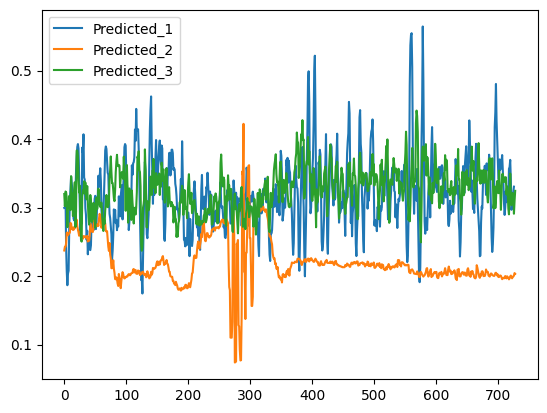

In [42]:
plt.plot(y_pred_1, label = 'Predicted_1')
plt.plot(y_pred_2, label = 'Predicted_2')
plt.plot(y_pred_3, label = 'Predicted_3')
plt.legend()

In [123]:
# scaler2 = MinMaxScaler()
# scaler2.min_,scaler2.scale_ = scaler.min_[5],scaler.scale_[5]

# scaler3 = MinMaxScaler()
# scaler3.min_,scaler3.scale_ = scaler_1.min_[5],scaler_1.scale_[5]

# scaler4 = MinMaxScaler()
# scaler4.min_,scaler4.scale_ = scaler_2.min_[5],scaler_2.scale_[5]

# scaler5 = MinMaxScaler()
# scaler5.min_,scaler5.scale_ = scaler_3.min_[5],scaler_3.scale_[5]

In [43]:
df_11 = pd.DataFrame(vect_11)
df_21 = pd.DataFrame(vect_21)
df_12 = pd.DataFrame(vect_12)
df_22 = pd.DataFrame(vect_22)

In [44]:
df_11.drop(df_11.index[0:41],axis=0,inplace=True)
df_21.drop(df_21.index[0:41],axis=0,inplace=True)
df_12.drop(df_12.index[0:41],axis=0,inplace=True)
df_22.drop(df_22.index[0:41],axis=0,inplace=True)

In [45]:
y_result = np.array(y_pred)
y_result_1 = np.array(y_pred_1)
y_result_2 = np.array(y_pred_2)
y_result_3 = np.array(y_pred_3)

In [46]:
y_result[0][0]

0.5313574

In [47]:
y_df_11 = []
y_df_21 = []
y_df_12 = []
y_df_22 = []
for x in range(len(y_result)-1):
    y_df_11.append(y_result[x][0])

for x in range(len(y_result_1)-1):
    y_df_21.append(y_result_1[x][0])

for x in range(len(y_result_2)-1):
    y_df_12.append(y_result_2[x][0])

for x in range(len(y_result_3)-1):
    y_df_22.append(y_result_3[x][0])

In [48]:
y_result = np.array(y_df_11)
y_result_1 = np.array(y_df_21)
y_result_2 = np.array(y_df_12)
y_result_3 = np.array(y_df_22)

In [49]:
df_11['LOS'] = y_result.tolist()
df_21['LOS'] = y_result_1.tolist()
df_12['LOS'] = y_result_2.tolist()
df_22['LOS'] = y_result_3.tolist()

In [200]:
#df_11.info()

In [201]:
#df_11['_id'][41]

In [50]:
for t in range(len(df_11)):

    base_de_datos.update_one(
        {"_id": ObjectId(str(df_11['_id'][41+t]))},
        {
            "$set":{
                "LOS": df_11['LOS'][41+t]
            }
        }
    )

for t in range(len(df_21)):

    base_de_datos.update_one(
        {"_id": ObjectId(str(df_21['_id'][41+t]))},
        {
            "$set":{
                "LOS": df_21['LOS'][41+t]
            }
        }
    )

for t in range(len(df_12)):

    base_de_datos.update_one(
        {"_id": ObjectId(str(df_12['_id'][41+t]))},
        {
            "$set":{
                "LOS": df_12['LOS'][41+t]
            }
        }
    )

for t in range(len(df_22)):

    base_de_datos.update_one(
        {"_id": ObjectId(str(df_22['_id'][41+t]))},
        {
            "$set":{
                "LOS": df_22['LOS'][41+t]
            }
        }
    )

Tenemos la segunda red neuronal

In [173]:
respuestas = base_de_datos.find({"LOS":{"$exists" : True}}).sort("_id",1)#.limit(500)  #1 significa de menor a mayor

# tag_1/Ant_1
vect_11 = []
# tag_2/Ant_1
vect_21 = []
# tag_1/Ant_2
vect_12 = []
# tag_2/Ant_2
vect_22 = []

for r in respuestas:
    if(r['Id_tag']== js["tag_1"] and r['Id_ant']==js["Antena_1"]):
        vect_11.append(r)
    elif(r['Id_tag']== js["tag_2"] and r['Id_ant']==js["Antena_1"]):
        vect_21.append(r)
    elif(r['Id_tag']== js["tag_1"] and r['Id_ant']==js["Antena_2"]):
        vect_12.append(r)
    elif(r['Id_tag']== js["tag_2"] and r['Id_ant']==js["Antena_2"]):
        vect_22.append(r)
    else:
        pass

df_11 = pd.DataFrame(vect_11)
df_21 = pd.DataFrame(vect_21)
df_12 = pd.DataFrame(vect_12)
df_22 = pd.DataFrame(vect_22)

In [179]:
df_11_l =  df_11.drop(['_id','hora','Id_tag','Id_ant','Canal'],axis=1)
if ('Distancia_corregida' in df_11_l.columns):
    df_11_l = df_11_l.drop(['Distancia_corregida'],axis=1)

df_21_l =  df_21.drop(['_id','hora','Id_tag','Id_ant','Canal'],axis=1)
if ('Distancia_corregida' in df_21_l.columns):
    df_21_l = df_21_l.drop(['Distancia_corregida'],axis=1)

df_12_l =  df_12.drop(['_id','hora','Id_tag','Id_ant','Canal'],axis=1)
if ('Distancia_corregida' in df_12_l.columns):
    df_12_l = df_12_l.drop(['Distancia_corregida'],axis=1)

df_22_l =  df_22.drop(['_id','hora','Id_tag','Id_ant','Canal'],axis=1)
if ('Distancia_corregida' in df_22_l.columns):
    df_22_l = df_22_l.drop(['Distancia_corregida'],axis=1)

In [180]:
scaler = MinMaxScaler()
scaler = scaler.fit(df_11_l)

scaler_1 = MinMaxScaler()
scaler_1 = scaler_1.fit(df_21_l)

scaler_2 = MinMaxScaler()
scaler_2 = scaler_2.fit(df_12_l)

scaler_3 = MinMaxScaler()
scaler_3 = scaler_3.fit(df_22_l)

In [181]:
df_11_l[['RSSI','Ang_azimuth','Ang_elevacion','Altura_ant','Distancia_ant_tag','LOS']] = scaler.transform (df_11_l[['RSSI','Ang_azimuth','Ang_elevacion','Altura_ant','Distancia_ant_tag','LOS']])
df_21_l[['RSSI','Ang_azimuth','Ang_elevacion','Altura_ant','Distancia_ant_tag','LOS']] = scaler_1.transform (df_21_l[['RSSI','Ang_azimuth','Ang_elevacion','Altura_ant','Distancia_ant_tag','LOS']])
df_12_l[['RSSI','Ang_azimuth','Ang_elevacion','Altura_ant','Distancia_ant_tag','LOS']] = scaler_2.transform (df_12_l[['RSSI','Ang_azimuth','Ang_elevacion','Altura_ant','Distancia_ant_tag','LOS']])
df_22_l[['RSSI','Ang_azimuth','Ang_elevacion','Altura_ant','Distancia_ant_tag','LOS']] = scaler_3.transform (df_22_l[['RSSI','Ang_azimuth','Ang_elevacion','Altura_ant','Distancia_ant_tag','LOS']])

In [159]:
df_11_l.head()

,RSSI,Ang_azimuth,Ang_elevacion,Altura_ant,Distancia_ant_tag,LOS
0,0.72,1.0,0.272727,0.0,0.857529,0.764958
1,0.88,1.0,0.272727,0.0,0.857529,0.773959
2,0.72,1.0,0.272727,0.0,0.857529,0.760148
3,1.00,1.0,0.272727,0.0,0.857529,0.745685
4,0.44,1.0,0.272727,0.0,0.857529,0.785146


In [182]:
time_steps = 3
X_test_0 = create_dataset(df_11_l,time_steps)
X_test_1 = create_dataset(df_21_l,time_steps)
X_test_2 = create_dataset(df_12_l,time_steps)
X_test_3 = create_dataset(df_22_l,time_steps)

In [183]:
# Modelo guardado en el PC
#from keras.models import model_from_json
import keras

name_json = "model_lstm.json"

# carga el json y crea el modelo
json_file = open(name_json,'r')
loaded_model_json = json_file.read()
json_file.close()

modelo = keras.models.model_from_json(loaded_model_json)
# se cargan los pesos (weights) en el nuevo modelo
modelo.load_weights("model_lstm.h5")
print("Modelo cargado desde el PC: ",name_json)
# se evalua el modelo cargado con los datos de los test

modelo.summary()

# X_test = np.expand_dims(X_test, -1)
# X_test_1 = np.expand_dims(X_test_1, -1)
# X_test_2 = np.expand_dims(X_test_2, -1)
# X_test_3 = np.expand_dims(X_test_3, -1)

Modelo cargado desde el PC:  model_lstm.json
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 32)                4992      
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
Total params: 5,792
Trainable params: 5,792
Non-trainable params: 0
_________________________________________________________________


In [184]:
y_pred_0_l = modelo.predict(X_test_0)
y_pred_1_l = modelo.predict(X_test_1)
y_pred_2_l = modelo.predict(X_test_2)
y_pred_3_l = modelo.predict(X_test_3)

23/23 [==============================] - 0s 1ms/step


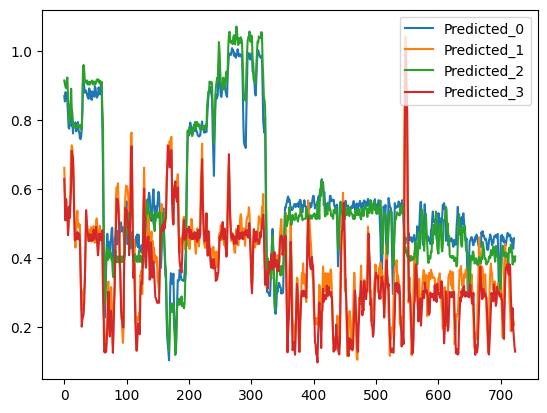

In [185]:
plt.plot(y_pred_0_l[:,5], label = 'Predicted_0')
plt.plot(y_pred_1_l[:,5], label = 'Predicted_1')
plt.plot(y_pred_2_l[:,5], label = 'Predicted_2')
plt.plot(y_pred_3_l[:,5], label = 'Predicted_3')
plt.legend()

In [186]:
scaler2 = MinMaxScaler()
scaler2.min_,scaler2.scale_ = scaler.min_[4],scaler.scale_[4]
scaler3 = MinMaxScaler()
scaler3.min_,scaler3.scale_ = scaler_1.min_[4],scaler_1.scale_[4]
scaler4 = MinMaxScaler()
scaler4.min_,scaler4.scale_ = scaler_2.min_[4],scaler_2.scale_[4]
scaler5 = MinMaxScaler()
scaler5.min_,scaler5.scale_ = scaler_3.min_[4],scaler_3.scale_[4]

In [155]:
scaler.data_range_

array([25.        ,  2.        , 44.        ,  0.        , 38.24365403,
        0.09501475])

In [187]:
y_pred_0_l_c = scaler2.inverse_transform([y_pred_0_l[:,5]])
y_pred_1_l_c = scaler3.inverse_transform([y_pred_1_l[:,5]])
y_pred_2_l_c = scaler4.inverse_transform([y_pred_2_l[:,5]])
y_pred_3_l_c = scaler5.inverse_transform([y_pred_3_l[:,5]])

In [188]:
df_11_l = pd.DataFrame(vect_11)
df_21_l = pd.DataFrame(vect_21)
df_12_l = pd.DataFrame(vect_12)
df_22_l = pd.DataFrame(vect_22)

In [189]:
df_11_l.drop(df_11_l.index[0:4],axis=0,inplace=True)
df_21_l.drop(df_21_l.index[0:4],axis=0,inplace=True)
df_12_l.drop(df_12_l.index[0:4],axis=0,inplace=True)
df_22_l.drop(df_22_l.index[0:4],axis=0,inplace=True)

In [190]:
y_result_0 = np.array(y_pred_0_l_c)
y_result_1 = np.array(y_pred_1_l_c)
y_result_2 = np.array(y_pred_2_l_c)
y_result_3 = np.array(y_pred_3_l_c)

In [169]:
y_pred_0_l_c.shape

(1, 722)

In [191]:
y_df_11_l = []
y_df_21_l = []
y_df_12_l = []
y_df_22_l = []
for x in range(len(y_result_0[0])-1):
    y_df_11_l.append(y_result_0[0][x])

for x in range(len(y_result_1[0])-1):
    y_df_21_l.append(y_result_1[0][x])

for x in range(len(y_result_2[0])-1):
    y_df_12_l.append(y_result_2[0][x])

for x in range(len(y_result_3[0])-1):
    y_df_22_l.append(y_result_3[0][x])

In [192]:
y_result_0 = np.array(y_df_11_l)
y_result_1 = np.array(y_df_21_l)
y_result_2 = np.array(y_df_12_l)
y_result_3 = np.array(y_df_22_l)

df_11_l['Distancia_corregida'] = y_result_0.tolist()
df_21_l['Distancia_corregida'] = y_result_1.tolist()
df_12_l['Distancia_corregida'] = y_result_2.tolist()
df_22_l['Distancia_corregida'] = y_result_3.tolist()

In [193]:
df_11_l['Distancia_corregida'][4+0]

264.3549590521525

In [194]:
for t in range(len(df_11_l)):

    base_de_datos.update_one(
        {"_id": ObjectId(str(df_11_l['_id'][4+t]))},
        {
            "$set":{
                "Distancia_corregida": df_11_l['Distancia_corregida'][4+t]
            }
        }
    )

for t in range(len(df_21_l)):

    base_de_datos.update_one(
        {"_id": ObjectId(str(df_21_l['_id'][4+t]))},
        {
            "$set":{
                "Distancia_corregida": df_21_l['Distancia_corregida'][4+t]
            }
        }
    )

for t in range(len(df_12_l)):

    base_de_datos.update_one(
        {"_id": ObjectId(str(df_12_l['_id'][4+t]))},
        {
            "$set":{
                "Distancia_corregida": df_12_l['Distancia_corregida'][4+t]
            }
        }
    )

for t in range(len(df_22_l)):

    base_de_datos.update_one(
        {"_id": ObjectId(str(df_22_l['_id'][4+t]))},
        {
            "$set":{
                "Distancia_corregida": df_22_l['Distancia_corregida'][4+t]
            }
        }
    )